# Train Simple Autoencoder

Pip installs for Colab

In [ ]:
!pip install wandb
!pip install torch
!pip install lightning
!pip install matplotlib
!pip install tqdm

In [ ]:
!wandb login 6ff71c9207e0564c7e57727b36e7272a588ea599 # Luke
#!wandb login 76a5fa31b18277c7da467875faee9a595d539767 # Henri

In [1]:
import torch
from torch.utils.data import DataLoader
import lightning as L
from torchvision import transforms
from lightning.pytorch.loggers import WandbLogger
from torchvision.datasets import MNIST

from autoencoder import AutoencoderSimple, Autoencoder12x12
from utils import plot_mnist_samples, plot_reconstruction_comparison, get_best_device

## Load the data and costruct dataloader

In [2]:
transform = transforms.Compose([
    transforms.Resize((12, 12)), # Train AE on mini Mnist
    transforms.ToTensor()
])

train_dataset = MNIST(root="./datasets", train=True,transform=transform, download=True)
test_dataset = MNIST(root="./datasets", train=False,transform=transform, download=True)

# Define the sizes for train, validation, and test sets
TRAIN_SIZE = int(0.9 * len(train_dataset))
VAL_SIZE = len(train_dataset) - TRAIN_SIZE
TEST_SIZE = len(test_dataset)
BATCH_SIZE = 100

train_data, val_data = torch.utils.data.random_split(
    train_dataset, [TRAIN_SIZE, VAL_SIZE]
)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Plot some sample images and labels from the dataset 


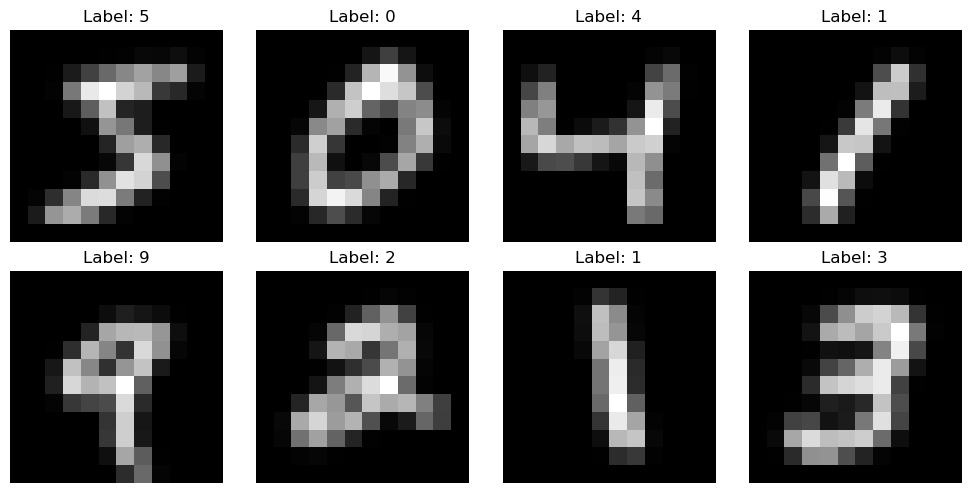

In [3]:
sample_images = [train_dataset[i][0].squeeze().numpy() for i in range(8)]
sample_labels = [train_dataset[i][1] for i in range(8)]
sample_captions = [f"Label: {label}" for label in sample_labels]
plot_mnist_samples(sample_images, sample_labels, sample_captions)

## Train the Autoencoder

In [4]:
#autoencoder = AutoencoderSimple()
autoencoder = Autoencoder12x12()

# Initialize a trainer
wandb_logger = WandbLogger(project="Autoencoder-Mini-MNIST", entity="network-to-network")
trainer = L.Trainer(max_epochs=100, logger=wandb_logger)

# Train the model
trainer.fit(autoencoder, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


: 

In [5]:
torch.save(autoencoder.state_dict(), 'ae_mini_100.pth')

## Test Autoencoder

In [4]:
def test_autoencoder(autoencoder, test_loader, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Tests the autoencoder on a batch from the test_loader and plots original and reconstructed images.
    :param autoencoder: The autoencoder model.
    :param test_loader: DataLoader for the test dataset.
    :param device: The device to run the model on.
    """
    autoencoder.eval()
    
    # Get a batch of test images
    images, _ = next(iter(test_loader))
    images = images.to(device)
    
    # Reconstruct images using the autoencoder
    with torch.no_grad():
        reconstructed_images = autoencoder(images)
    
    # Prepare images for display
    original_images = images.cpu()
    reconstructed_images = reconstructed_images.cpu()
    
    # Plot original and reconstructed images
    plot_reconstruction_comparison(original_images, reconstructed_images)

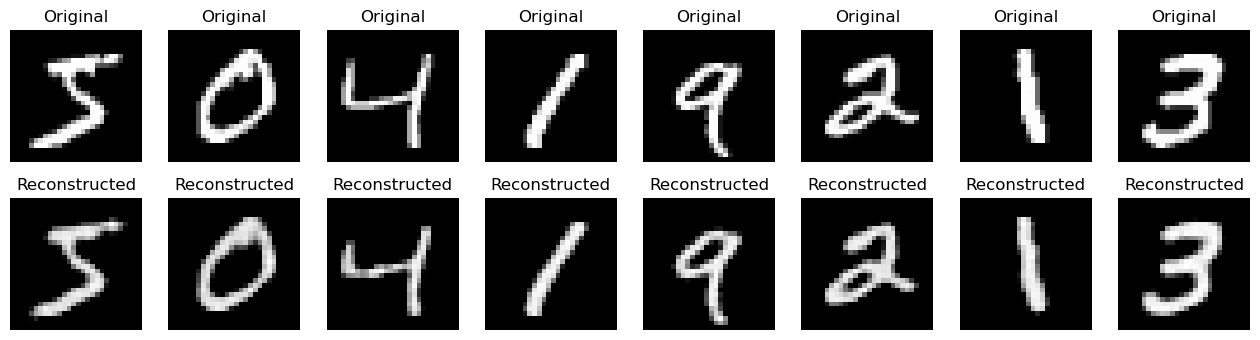

In [6]:
ae_path = "./models/ae_100_new.pth"
autoencoder = AutoencoderSimple()
autoencoder.load_state_dict(torch.load(ae_path, map_location=get_best_device()))

test_autoencoder(autoencoder, test_loader, device='cpu')